In [1]:
import os
import glob
import ctypes
import h5py
import numpy as np
from tqdm import tqdm

In [2]:
try:
    conda_prefix = os.environ.get('CONDA_PREFIX', '')
    dll_path = os.path.join(conda_prefix, 'Library', 'bin', 'zlibwapi.dll')
    ctypes.CDLL(dll_path)
    print(f"Loaded zlibwapi.dll from {dll_path}")
except Exception as e:
    print(f"Could not load zlibwapi.dll: {e}")

import tensorflow as tf
from tensorflow.keras import layers, models


Loaded zlibwapi.dll from C:\Users\dhanu\.conda\envs\w\Library\bin\zlibwapi.dll


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} GPU(s) detected")
else:
    print("No GPU detected, training will run on CPU")


1 GPU(s) detected


# Configuration

In [4]:
DATA_DIR    = r"C:\college\CV\COSMOS\6C_data"
SEQ_LEN     = 3                # Number of past frames to use
PATCH_SIZE  = 128              # Training patch size
BATCH_SIZE  = 4
EPOCHS      = 10
THRESHOLD   = 265.0            # Cloud mask threshold (K)
MODEL_PATH  = r"C:\college\CV\COSMOS\cloud_nowcast_model.h5"


# File list & sequence grouping


In [5]:
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.h5")))
sequences = [all_files[i:i + SEQ_LEN + 1] for i in range(len(all_files) - SEQ_LEN)]

# Data loading & augmentation


In [6]:
def load_sequence(seq_files):
    """Loads SEQ_LEN frames and computes the target cloud mask."""
    frames = []
    for fp in seq_files[:SEQ_LEN]:
        with h5py.File(fp, 'r') as f:
            counts = f['IMG_TIR1'][0]            # (H, W)
            lut    = f['IMG_TIR1_TEMP'][:]       # (1024,)
            frames.append(lut[counts])
    # target mask
    with h5py.File(seq_files[-1], 'r') as f:
        counts = f['IMG_TIR1'][0]
        lut    = f['IMG_TIR1_TEMP'][:]
        bt     = lut[counts]
        mask   = (bt < THRESHOLD).astype(np.float32)
    X = np.stack(frames, axis=0)[..., np.newaxis]  # (SEQ_LEN, H, W, 1)
    y = mask[..., np.newaxis]                      # (H, W, 1)
    return X, y

def random_crop(X, y, size):
    """Randomly crops a patch of shape (SEQ_LEN, size, size, 1) and (size, size, 1)."""
    t, H, W, _ = X.shape
    i = np.random.randint(0, H - size)
    j = np.random.randint(0, W - size)
    return X[:, i:i+size, j:j+size, :], y[i:i+size, j:j+size, :]

def data_generator(seqs, batch_size):
    """Yields batches of (X, y) with random crops."""
    while True:
        idxs = np.random.permutation(len(seqs))
        for start in range(0, len(seqs), batch_size):
            batch_ids = idxs[start:start + batch_size]
            Xb, yb = [], []
            for bid in batch_ids:
                X, y = load_sequence(seqs[bid])
                Xc, yc = random_crop(X, y, PATCH_SIZE)
                Xb.append(Xc); yb.append(yc)
            yield np.stack(Xb), np.stack(yb)

# Split into train/validation
split_idx = int(0.9 * len(sequences))
train_seqs = sequences[:split_idx]
val_seqs   = sequences[split_idx:]
steps_per_epoch   = len(train_seqs) // BATCH_SIZE
validation_steps  = len(val_seqs)   // BATCH_SIZE

train_gen = data_generator(train_seqs, BATCH_SIZE)
val_gen   = data_generator(val_seqs, BATCH_SIZE)


# Model definition: ConvLSTM2D


In [7]:
inputs = layers.Input((SEQ_LEN, PATCH_SIZE, PATCH_SIZE, 1))
x = layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Custom IoU metric
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return inter / (union + 1e-7)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[iou_metric, 'accuracy'])


# Training loop with tqdm


In [8]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    # Training
    train_bar = tqdm(range(steps_per_epoch), desc='Train', unit='batch')
    for _ in train_bar:
        Xb, yb = next(train_gen)
        loss, iou, acc = model.train_on_batch(Xb, yb)
        train_bar.set_postfix({'loss': f"{loss:.4f}", 'iou': f"{iou:.4f}", 'acc': f"{acc:.4f}"})
    # Validation
    val_bar = tqdm(range(validation_steps), desc='Val', unit='batch')
    val_metrics = []
    for _ in val_bar:
        Xv, yv = next(val_gen)
        v_loss, v_iou, v_acc = model.test_on_batch(Xv, yv)
        val_bar.set_postfix({'v_loss': f"{v_loss:.4f}", 'v_iou': f"{v_iou:.4f}", 'v_acc': f"{v_acc:.4f}"})
        val_metrics.append((v_loss, v_iou, v_acc))
    # average validation metrics
    v_loss, v_iou, v_acc = np.mean(val_metrics, axis=0)
    print(f"Val — loss: {v_loss:.4f}, iou: {v_iou:.4f}, acc: {v_acc:.4f}")



Epoch 1/10


Val: 100%|██████████| 5/5 [00:10<00:00,  2.05s/batch, v_loss=1.0189, v_iou=0.0000, v_acc=0.8538]


Val — loss: 1.5171, iou: 0.0000, acc: 0.7789

Epoch 2/10


Val: 100%|██████████| 5/5 [00:09<00:00,  1.82s/batch, v_loss=1.4439, v_iou=0.0000, v_acc=0.5100]


Val — loss: 0.6940, iou: 0.0000, acc: 0.7654

Epoch 3/10


Val: 100%|██████████| 5/5 [00:08<00:00,  1.61s/batch, v_loss=0.3558, v_iou=0.0000, v_acc=0.8193]


Val — loss: 0.6802, iou: 0.0000, acc: 0.7403

Epoch 4/10


Val: 100%|██████████| 5/5 [00:07<00:00,  1.60s/batch, v_loss=0.0461, v_iou=0.0000, v_acc=0.9900]


Val — loss: 0.5443, iou: 0.0519, acc: 0.7826

Epoch 5/10


Val: 100%|██████████| 5/5 [00:08<00:00,  1.60s/batch, v_loss=0.5910, v_iou=0.0001, v_acc=0.7328]


Val — loss: 0.6902, iou: 0.1304, acc: 0.7087

Epoch 6/10


Val: 100%|██████████| 5/5 [00:08<00:00,  1.61s/batch, v_loss=2.6421, v_iou=0.0002, v_acc=0.0002]


Val — loss: 1.0116, iou: 0.0002, acc: 0.6605

Epoch 7/10


Val: 100%|██████████| 5/5 [00:09<00:00,  1.91s/batch, v_loss=1.0181, v_iou=0.0030, v_acc=0.5933]


Val — loss: 1.0034, iou: 0.0262, acc: 0.5785

Epoch 8/10


Val: 100%|██████████| 5/5 [00:07<00:00,  1.60s/batch, v_loss=0.1833, v_iou=0.1365, v_acc=0.9494]


Val — loss: 0.4091, iou: 0.3347, acc: 0.7919

Epoch 9/10


Val: 100%|██████████| 5/5 [00:08<00:00,  1.60s/batch, v_loss=0.2178, v_iou=0.0007, v_acc=0.9122]


Val — loss: 0.5979, iou: 0.1238, acc: 0.6815

Epoch 10/10


Val: 100%|██████████| 5/5 [00:08<00:00,  1.60s/batch, v_loss=0.3227, v_iou=0.5613, v_acc=0.7940]

Val — loss: 0.2936, iou: 0.8070, acc: 0.9027


# Save the trained model


In [9]:
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to C:\college\CV\COSMOS\cloud_nowcast_model.h5


1/1 [==============================] - 0s 31ms/step


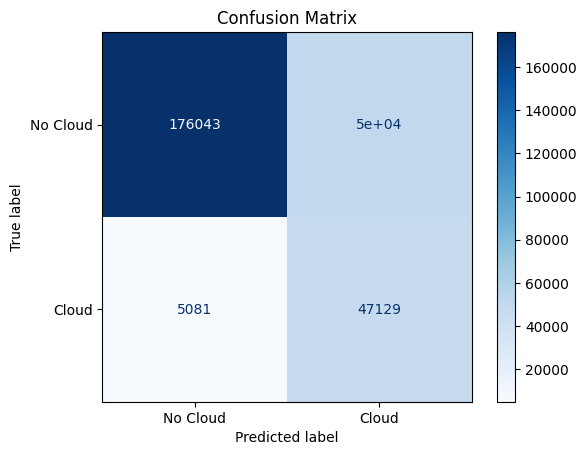

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions and true labels from the validation set
def evaluate_model_with_confusion_matrix(val_gen, steps, model):
    y_true = []
    y_pred_prob = []  # Store probabilities for ROC curve

    for _ in range(steps):
        Xv, yv = next(val_gen)
        preds = model.predict(Xv)
        y_pred_prob.extend(preds.flatten())  # Store probabilities
        preds_binary = (preds > 0.5).astype(int)  # Binarize predictions
        y_true.extend(yv.flatten())

    y_true = np.array(y_true)
    y_pred_binary = np.array((np.array(y_pred_prob) > 0.5).astype(int))  # Convert probabilities to binary predictions
    y_pred_prob = np.array(y_pred_prob)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Cloud", "Cloud"])

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print overall metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"AUC: {roc_auc:.4f}")


# Call the function with validation generator
evaluate_model_with_confusion_matrix(val_gen, validation_steps, model)